In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
from sustaingym.envs.evcharging.utils import load_gmm_model

In [4]:
from sustaingym.envs.evcharging import create_gmm
from datetime import datetime

create_gmm(site='jpl', n_components=50, date_range=(datetime(2020, 2, 1), datetime(2020, 5, 31)))

Fetching data from site Jpl for date range 2020-02-01 2020-05-31... 


KeyboardInterrupt: 

In [3]:
cnt = load_gmm_model('gmms_ev_charging/jpl/2020-02-01 2020-05-31 50')['count']
cnt.min(), cnt.max(), len(cnt), cnt.dtype

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/sustaingym/sustaingym/envs/evcharging/gmms_ev_charging/jpl/2020-02-01 2020-05-31 50/model.pkl'

In [28]:
cnt = load_gmm_model('gmms_ev_charging/jpl/2021-05-01 2021-08-31 50')['count']
cnt.min(), cnt.max(), len(cnt)

(1, 56, 113)

In [29]:
cnt = load_gmm_model('gmms_ev_charging/caltech/2021-05-01 2021-08-31 50')['count']
cnt.min(), cnt.max(), len(cnt)

(3, 26, 123)

In [7]:
SITE = 'caltech'
MODEL = 'ppo'
TRAIN_DATE_RANGE = 'Summer 2019'
TEST_DATE_RANGE = 'Spring 2020'

# Imports

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
from stable_baselines3 import PPO, DQN

from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from sustaingym.algorithms.evcharging.base_algorithm import SelectiveChargingAlgorithm, GreedyAlgorithm, PPOAlgorithm, RandomAlgorithm
from sustaingym.envs.evcharging import EVChargingEnv, RealTraceGenerator, GMMsTraceGenerator, DEFAULT_PERIOD_TO_RANGE

[autoreload of sustaingym.algorithms.evcharging.base_algorithm failed: Traceback (most recent call last):
  File "/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/IPyt

In [91]:
from datetime import datetime, timedelta
import pandas as pd

DATE_FORMAT = "%Y-%m-%d"

def collect_rewards(algs, date_period, num_days=-1):
    begin = datetime.strptime(DEFAULT_PERIOD_TO_RANGE[date_period][0], DATE_FORMAT)
    end = datetime.strptime(DEFAULT_PERIOD_TO_RANGE[date_period][1], DATE_FORMAT)
    days_diff = end - begin

    if num_days == -1:
        num_days_sim = days_diff.days + 1
    else:
        num_days_sim = num_days

    results = {}
    for alg in algs:
        print(f"Running {alg.name}")
        results[alg] = alg.run(num_days_sim)
    results = {alg.name: reward for alg, reward in results.items()}

    results['dates'] = [begin + timedelta(days=i) for i in range(num_days_sim)]

    results = pd.DataFrame(results)
    results.set_index('dates', inplace=True)
    return results

date_ranges = [TRAIN_DATE_RANGE, TEST_DATE_RANGE]
heuristics_rewards = []

for date_range in date_ranges:
    gen = GMMsTraceGenerator(site=SITE, date_period=date_range, random_seed=123)
    env = EVChargingEnv(gen, action_type='continuous', verbose=1, project_action=False)

    env.reset()
    algs = [
        RandomAlgorithm(env),
        SelectiveChargingAlgorithm(env, rate=1.0),
        GreedyAlgorithm(env)
    ]
    heuristics_rewards.append(collect_rewards(algs, date_range, num_days=7))

Simulating 40 plug in events. 
Running random
Simulating 23 plug in events. 
Simulating 6 plug in events. 
Simulating 31 plug in events. 
Simulating 40 plug in events. 
Simulating 8 plug in events. 
Simulating 33 plug in events. 
Simulating 32 plug in events. 
Running selective charge @ rate 8.0 A
Simulating 23 plug in events. 
Simulating 6 plug in events. 
Simulating 31 plug in events. 
Simulating 40 plug in events. 
Simulating 8 plug in events. 
Simulating 33 plug in events. 
Simulating 32 plug in events. 
Running optimal greedy
Simulating 23 plug in events. 
Simulating 6 plug in events. 
Simulating 31 plug in events. 
Simulating 40 plug in events. 
Simulating 8 plug in events. 
Simulating 33 plug in events. 
Simulating 32 plug in events. 
Simulating 35 plug in events. 
Running random
Simulating 2 plug in events. 
Simulating 1 plug in events. 
Simulating 24 plug in events. 
Simulating 1 plug in events. 
Simulating 11 plug in events. 
Simulating 34 plug in events. 
Simulating 1 plug i

In [92]:
# Summer 2019
heuristics_rewards[0].describe().loc[['mean', 'std']]

,random,selective charge @ rate 8.0 A,optimal greedy
mean,-132.829288,-3.998331,0.432308
std,2.853186,1.932405,0.895232


In [93]:
# Spring 2020
heuristics_rewards[1].describe().loc[['mean', 'std']]


,random,selective charge @ rate 8.0 A,optimal greedy
mean,-133.993515,-1.966367,-0.032042
std,3.009553,2.701136,0.895774


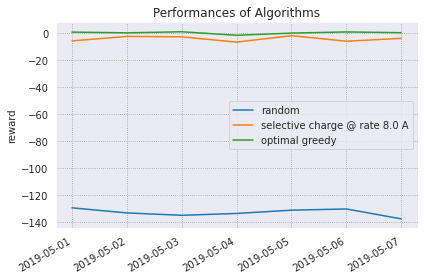

In [94]:
plt.title("Performances of Algorithms")
for col in heuristics_rewards[0].columns:
    plt.plot(heuristics_rewards[0][col], label=col)
plt.ylabel('reward')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

# Train a PPO Agent

In [55]:
def get_env(train=True):
    date_period = TRAIN_DATE_RANGE if train else TEST_DATE_RANGE

    def _get_env():
        gen = GMMsTraceGenerator(site=SITE, date_period=date_period, random_seed=42)
        return EVChargingEnv(gen, action_type='discrete', project_action=False)

    return _get_env

vec_env = SubprocVecEnv([get_env(train=True) for _ in range(4)])
train_env = get_env(train=True)()
eval_env = get_env(train=False)()

save_path = f'./logs/{MODEL}/eval_on_'
train_save_path = save_path + 'train'
eval_save_path = save_path + 'eval'
# Use deterministic actions for evaluation
eval_on_train_callback = EvalCallback(train_env, best_model_save_path=train_save_path,
                                      log_path=train_save_path, eval_freq=1000,
                                      deterministic=True, render=False)
eval_on_eval_callback = EvalCallback(eval_env, best_model_save_path=eval_save_path,
                                     log_path=eval_save_path, eval_freq=1000,
                                     deterministic=True, render=False)
callback = CallbackList([eval_on_train_callback, eval_on_eval_callback])

In [60]:
if MODEL == 'ppo':
    model = PPO('MultiInputPolicy', vec_env)
else:
    model = DQN('MultiInputPolicy', vec_env)

model.learn(total_timesteps=250_000, callback=callback)

Eval num_timesteps=4000, episode_reward=-123.50 +/- 5.10
Episode length: 160.60 +/- 8.96
New best mean reward!
Eval num_timesteps=4000, episode_reward=-125.84 +/- 15.45
Episode length: 161.60 +/- 10.86
New best mean reward!
Eval num_timesteps=8000, episode_reward=-131.75 +/- 9.52
Episode length: 165.20 +/- 9.41
Eval num_timesteps=8000, episode_reward=-131.96 +/- 15.29
Episode length: 159.60 +/- 9.77
Eval num_timesteps=12000, episode_reward=-78.30 +/- 8.69
Episode length: 162.20 +/- 10.03
New best mean reward!
Eval num_timesteps=12000, episode_reward=-81.97 +/- 9.83
Episode length: 164.00 +/- 6.84
New best mean reward!
Eval num_timesteps=16000, episode_reward=-85.42 +/- 8.93
Episode length: 163.60 +/- 6.83
Eval num_timesteps=16000, episode_reward=-67.34 +/- 5.64
Episode length: 162.20 +/- 10.26
New best mean reward!
Eval num_timesteps=20000, episode_reward=-78.54 +/- 19.07
Episode length: 163.00 +/- 9.78
Eval num_timesteps=20000, episode_reward=-52.99 +/- 6.29
Episode length: 149.80 +/-

In [75]:
# 1.5 hours for 250_000 timesteps
model.save(f'./logs/{MODEL}/model_250k_timesteps')

In [85]:
rewards_for_ranges = dict()
for env, date_range in zip([train_env, eval_env], [TRAIN_DATE_RANGE, TEST_DATE_RANGE]):
    rl_algo = PPOAlgorithm(env, model)
    model_rewards = collect_rewards([rl_algo], date_range, num_days=7)
    rewards_for_ranges[date_range] = model_rewards.reset_index().drop('dates', axis=1)

Running PPO algorithm
Running PPO algorithm


In [89]:
pd.concat(rewards_for_ranges, axis=1).describe()

,Summer 2019,Spring 2020
,PPO algorithm,PPO algorithm
count,7.000000,7.000000
mean,-72.858100,-63.429204
std,5.704884,9.163363
min,-80.548672,-79.982451
25%,-76.499261,-66.679264
50%,-75.002159,-63.349539
75%,-67.884670,-57.400650
max,-65.688007,-52.512613


In [88]:
loaded_model_on_train = PPO.load(f'./logs/{MODEL}/model_250k_timesteps')

rl_algo = PPOAlgorithm(train_env, loaded_model_on_train)
loaded_model_on_train_rewards = collect_rewards([rl_algo], TRAIN_DATE_RANGE, num_days=7)
loaded_model_on_train_rewards

Running PPO algorithm


,PPO algorithm
dates,
2019-05-01,-67.984443
2019-05-02,-77.536237
2019-05-03,-78.278045
2019-05-04,-70.180299
2019-05-05,-72.032631
2019-05-06,-76.875832
2019-05-07,-71.447150


4 m 5 s for 10_000 no callbacks
4 m 4 s 5_000 callbacks

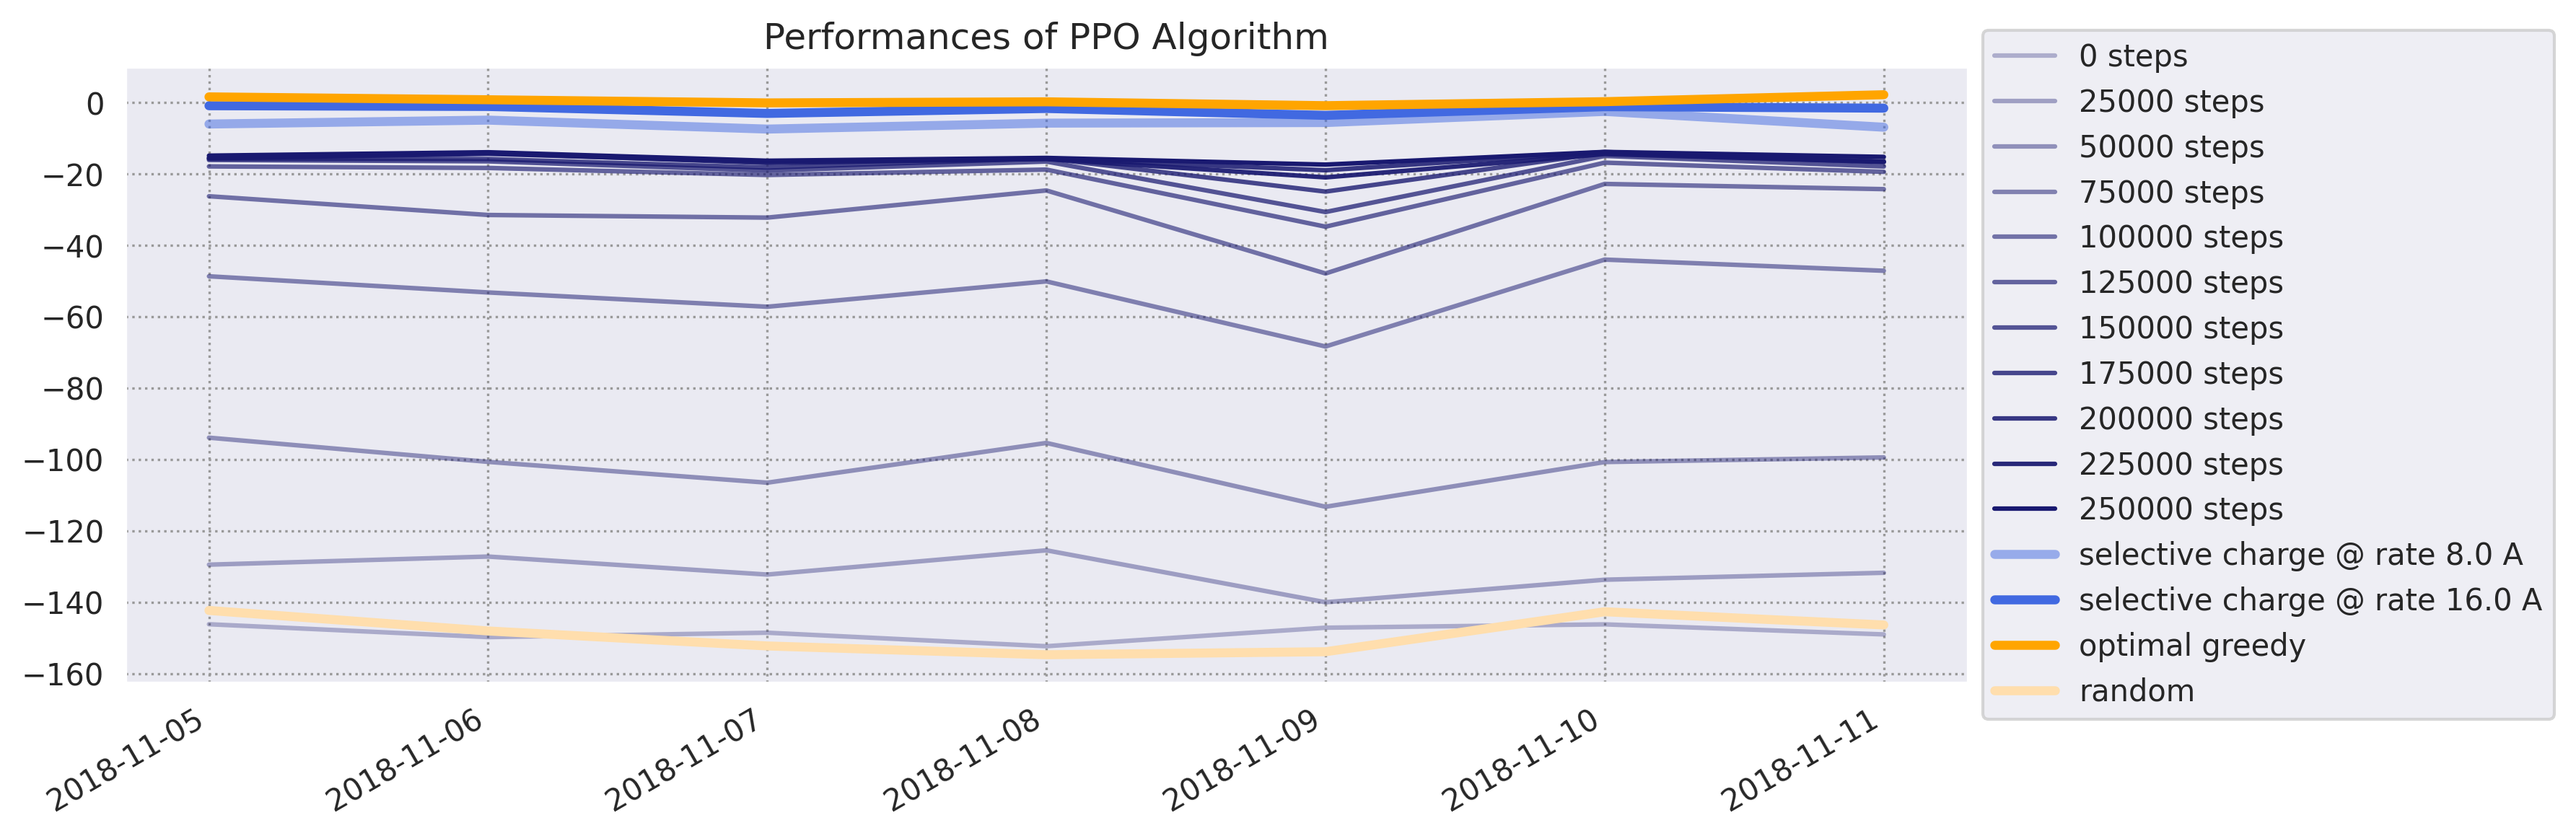

In [42]:
# plt.figure(figsize=(12, 4), dpi=300)

# training_results = pd.concat([trained_rewards[i * timesteps] for i in range(11)], axis=1)
# training_results.columns = [f"{i * timesteps} steps" for i in range(11)]
# training_results

# all_results = pd.concat((training_results, heuristics_rewards), axis=1)

# plt.title("Performances of PPO Algorithm")
# for col in all_results.columns:
#     if 'steps' in col:
#         alpha = 0.3 + 0.7 * int(col.split(' ')[0]) / 250000
#         plt.plot(all_results[col], label=col, alpha=alpha, color='midnightblue')
#     elif 'charge' in col and '8.0' in col:
#         plt.plot(all_results[col], label=col, color='royalblue', alpha=0.5, lw=3.)
#     elif 'charge' in col and '16.0' in col:
#         plt.plot(all_results[col], label=col, color='royalblue', alpha=1.0, lw=3.)
#     elif 'random' in col:
#         plt.plot(all_results[col], label=col, color='navajowhite', lw=3.)
#     else:
#         plt.plot(all_results[col], label=col, color='orange', lw=3.)
# plt.gcf().autofmt_xdate()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout()
# plt.show()